In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [180]:
path ='/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/'
raw_data = sio.loadmat(path + 'Simulation_noisy_STO_slice_3_1000FPS_fullsize.mat')
raw_data = raw_data['datacube']
truth_data = np.load(path + 'Simulation_truth_STO_slice_3_1000FPS_fullsize.npy')

In [181]:
import h5py
denoised_data = {}
f = h5py.File(path + 'Simulation_tensor_STO_slice_3_1000FPS_fullsize.mat')
for k, v in f.items():
    denoised_data[k] = np.array(v)
denoised_data = denoised_data['est_HOOI']

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [182]:
print(denoised_data.shape)
print(raw_data.shape)
print(truth_data.shape)

(16384, 150, 150)
(150, 150, 16384)
(150, 150, 16384)


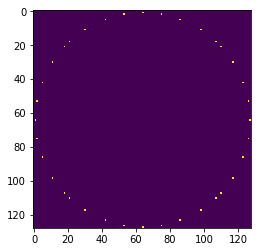

In [9]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=63) & \
~create_circular_mask(128, 128, center=(64,64), radius=62.95)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[i*128+j,:,:]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

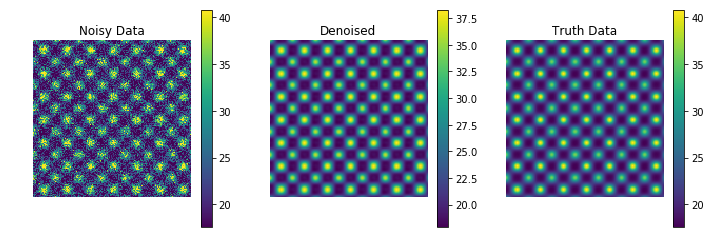

In [187]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(np.transpose(ADF_denoised))
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

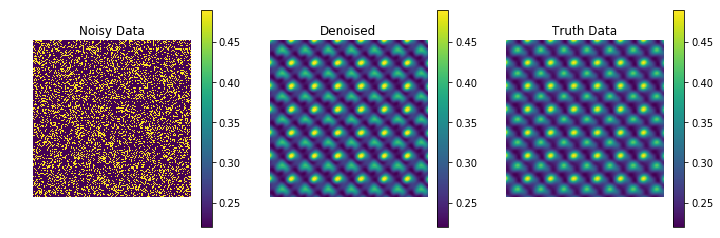

In [11]:
# Compare real space structure from single kx,ky
plt.figure(figsize=(12,4))
iframe = 1000
clim_low = np.amin(truth_data[:,:,iframe])
clim_high = np.amax(truth_data[:,:,iframe])

plt.subplot(132)
plt.imshow(np.transpose(denoised_data[iframe,:,:]),clim=[clim_low,clim_high])
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(raw_data[:,:,iframe],clim=[clim_low,clim_high])
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(truth_data[:,:,iframe],clim=[clim_low,clim_high])
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

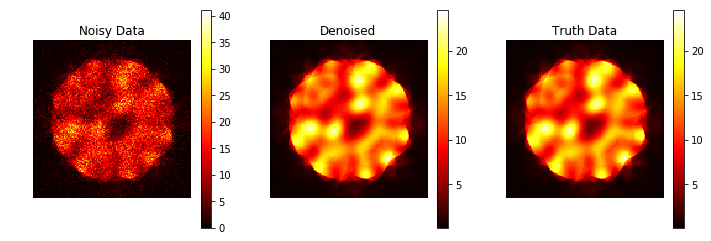

In [11]:
# Compare CBED from single rx,ry
plt.figure(figsize=(12,4))
rx = 50
ry = 50
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

plt.subplot(132)
plt.imshow(np.transpose(denoised_data[:,rx,ry].reshape(128,128)),clim=[clim_low,clim_high],cmap='hot')
plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),cmap='hot')
plt.title('Noisy Data')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.title('Truth Data')
plt.axis('off')
plt.colorbar()

# print(psnr(truth_data[rx,ry,:].reshape(128,128),tensor_data[rx,ry,:].reshape(128,128)))

In [18]:
# calculate SSIM for each real space position, result in Decibel
from skimage import data, img_as_float
from skimage.measure import compare_ssim
ssim_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))

for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:].reshape(128,128)
        denoise = np.transpose(denoised_data[:,irow,icol].reshape(128,128))
        (score, diff) = compare_ssim(truth, denoise, full=True)
        ssim_map[irow,icol] = score

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


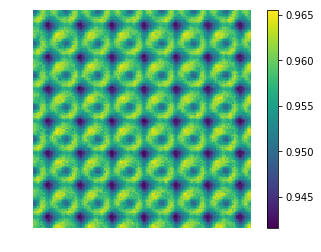

In [20]:
plt.imshow(ssim_map)
plt.axis('off')
plt.colorbar()

In [15]:
# calculate PSNR for each real space position, result in Decibel
psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
for irow in range(truth_data.shape[0]):
    for icol in range(truth_data.shape[1]):
        truth = truth_data[irow,icol,:].reshape(128,128)
        denoise = np.transpose(denoised_data[:,irow,icol].reshape(128,128))
        psnr_map[irow,icol] = psnr(truth,denoise)

40.76021350160346


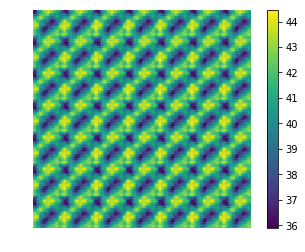

In [16]:
plt.imshow(psnr_map)
plt.colorbar()
plt.axis('off')
print(np.mean(psnr_map))

In [34]:
FPS = 1000
truth_file = path + 'Simulation_truth_STO_slice_3_'+str(FPS)+'FPS_fullsize.npy'
noisy_file = path + 'Simulation_noisy_STO_slice_3_'+str(FPS)+'FPS_fullsize.mat'
denoise_file = path + 'Simulation_tensor_STO_slice_3_'+str(FPS)+'FPS_fullsize.mat'
truth_file = np.load(truth_file)
noisy_file = sio.loadmat(noisy_file)
noisy_file = noisy_file['datacube']

denoise_file = {}
f = h5py.File(path + 'Simulation_tensor_STO_slice_3_'+str(FPS)+'FPS_fullsize.mat')
for k, v in f.items():
    denoise_file[k] = np.array(v)
denoise_file = denoise_file['est_HOOI']

print(averagePSNR(denoise_file,truth_file,1))
print(averagePSNR(noisy_file,truth_file,0))

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # Remove the CWD from sys.path while we load stuff.


40.76021350160346
20.441666372169813


In [37]:
# Plot input vs output psnr
FPS_list = [1000,2000,4000,6000,8000,20000,40000]
PSNR_list = np.zeros((2,len(FPS_list)))
path = '/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/'
for i in range(len(FPS_list)):
    FPS = FPS_list[i]
    truth_file = path + 'Simulation_truth_STO_slice_3_'+str(FPS)+'FPS_fullsize.npy'
    noisy_file = path + 'Simulation_noisy_STO_slice_3_'+str(FPS)+'FPS_fullsize.mat'
    denoise_file = path + 'Simulation_tensor_STO_slice_3_'+str(FPS)+'FPS_fullsize.mat'
    truth_file = np.load(truth_file)
    noisy_file = sio.loadmat(noisy_file)
    noisy_file = noisy_file['datacube']

    denoise_file = {}
    f = h5py.File(path + 'Simulation_tensor_STO_slice_3_'+str(FPS)+'FPS_fullsize.mat')
    for k, v in f.items():
        denoise_file[k] = np.array(v)
    denoise_file = denoise_file['est_HOOI']
    
    PSNR_list[0,i] = averagePSNR(denoise_file,truth_file,1)
    PSNR_list[1,i] = averagePSNR(noisy_file,truth_file,0)
    print(FPS)
    print(averagePSNR(denoise_file,truth_file,1))
    print(averagePSNR(noisy_file,truth_file,0))

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  from ipykernel import kernelapp as app


1000
40.76021350160346
20.441666372169813
2000
40.74771433711406
17.43227473867307
4000
39.47661483719467
14.421471282354045
6000
38.77687819804639
12.661289185492043
8000
38.20082306306612
11.412151116858885
20000
35.77715101286905
7.433980930854093
40000
33.382461614314664
4.42140577489312


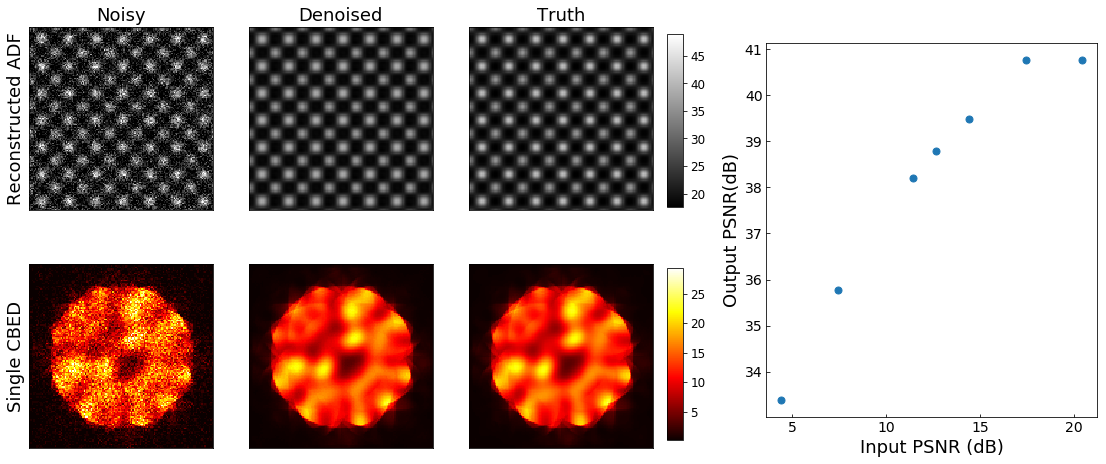

In [168]:
# overall plot
fig = plt.figure(figsize=(23,8))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)


fig.add_subplot(261)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Noisy',fontsize=18)
plt.ylabel('Reconstructed ADF', fontsize=18)

fig.add_subplot(262)
plt.imshow(np.transpose(ADF_denoised),clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Denoised',fontsize=18)

ax = fig.add_subplot(263)
im = plt.imshow(ADF_truth,clim=[clim_low,clim_high*1.2],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Truth',fontsize=18)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)
cax = fig.add_axes([0.51,0.555,0.01,0.3])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)

# cbar = plt.colorbar(fraction = 0.046, pad = 0.05)
# cbar.ax.tick_params(labelsize = 12)
# cbar.set_label('Electron Counts',rotation=270)

# plot CBED patterns
rx = 50
ry = 50
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

fig.add_subplot(267)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
plt.ylabel('Single CBED', fontsize=18)

fig.add_subplot(268)
plt.imshow(np.transpose(denoised_data[:,rx,ry].reshape(128,128)),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(269)
im = plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high*1.2],cmap='hot')
plt.xticks([])
plt.yticks([])
divider = make_axes_locatable(ax)

cax = fig.add_axes([0.51,0.15,0.01,0.3])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)
# cbar.set_label('Electron Counts',rotation=270,fontsize=14)

ax3 = fig.add_axes([0.57,0.19,0.2,0.65])
# ax3 = plt.subplot2grid((2, 7), (0, 5), colspan=2, rowspan=2)
ax3.plot(PSNR_list[1,:], PSNR_list[0,:], '.',markersize=14)
plt.xlabel('Input PSNR (dB)',fontsize=18)
plt.ylabel('Output PSNR(dB)',fontsize=18)
ax3.tick_params(direction='in',labelsize = 14)

# fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
fig.savefig('/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/PSNR_tensor_fullsize.tif')

(-0.5, 113.5, 113.5, -0.5)

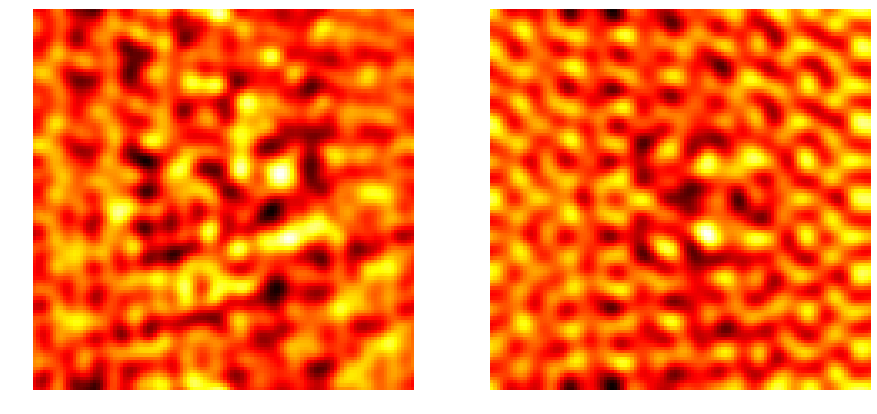

In [192]:
# Visulize different components along the third dimension
path ='/srv/home/chenyu/TensorDenoise/VisulizeComponent/'
raw_data = sio.loadmat(path + 'Components_SiDisl_slc5_1000FPS_fullsize.mat')
raw_data = raw_data['prototype']

fig = plt.figure(figsize=(15,8))
fig.add_subplot(121)
plt.imshow(raw_data[:,:,79],cmap='hot')
plt.axis('off')

fig.add_subplot(122)
plt.imshow(raw_data[:,:,33],cmap='hot')
plt.axis('off')

In [68]:
scree = temp['scree3']
scree = scree[::-1]
print(scree[30])

[0.92740888]


Text(0.5, 0, 'Components')

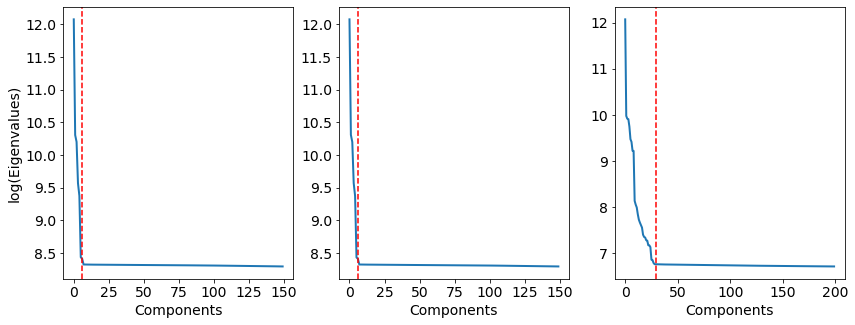

In [6]:
# Analysis eigenvalues
temp = sio.loadmat('/srv/home/chenyu/TensorDenoise/Simulatons/STO_simulation/Simulation_noisy_STO_slice_5_1000FPS_fullsize_eigenvalue.mat')

fig = plt.figure(figsize=(14,5))

fig.add_subplot(131)
e1 = temp['e1']
plt.plot(np.log(e1[::-1]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=6,color='r',ls='--')
plt.ylabel('log(Eigenvalues)',fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(132)
e2 = temp['e2']
plt.plot(np.log(e2[::-1]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=6,color='r',ls='--')
# plt.ylabel('Eigenvalues',fontsize=14)
plt.xlabel('Components',fontsize=14)

fig.add_subplot(133)
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.log(e3[:200]),linewidth='2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=29,color='r',ls='--')
# plt.ylabel('Eigenvalues',fontsize=14)
plt.xlabel('Components',fontsize=14)

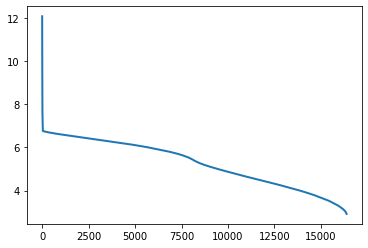

In [7]:
e3 = temp['e3']
e3 = e3[::-1]
plt.plot(np.log(e3),linewidth='2')
# plt.axvline(x=29,color='r',ls='--')

In [14]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [8]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [33]:
# transpose_option = 1 for tensor denoised data, where first dimension is for rec space and need to be transposed to match simulation
# transpose_option = 0 for noisy data, third dimension is for rec space and no need to transpose
def averagePSNR(denoised_data,truth_data,transpose_option):
    for irow in range(truth_data.shape[0]):
        for icol in range(truth_data.shape[1]):
            truth = truth_data[irow,icol,:].reshape(128,128)
            if transpose_option == 1:
                denoise = np.transpose(denoised_data[:,irow,icol].reshape(128,128))
            else:
                denoise = denoised_data[irow,icol,:].reshape(128,128)
            psnr_map[irow,icol] = psnr(truth,denoise)
    return np.mean(psnr_map)